### Step 1: Initial Data Exploration

In [2]:
# Import libraries
import pandas as pd

#  Load the dataset
df = pd.read_csv('spotifydataset.csv')

# Check the first few rows to confirm it loaded correctly
print(df.head())

   Unnamed: 0    artist_name genres  followers  artist_popularity  \
0           0  Ariana Grande    pop   98934105                 89   
1           1  Ariana Grande    pop   98934105                 85   
2           2  Ariana Grande    pop   98934105                 83   
3           3  Ariana Grande    pop   98934105                 80   
4           4  Ariana Grande    pop   98934105                 79   

                                          artist_url  \
0  https://open.spotify.com/artist/66CXWjxzNUsdJx...   
1  https://open.spotify.com/artist/66CXWjxzNUsdJx...   
2  https://open.spotify.com/artist/66CXWjxzNUsdJx...   
3  https://open.spotify.com/artist/66CXWjxzNUsdJx...   
4  https://open.spotify.com/artist/66CXWjxzNUsdJx...   

                                          track_name            album_name  \
0           we can't be friends (wait for your love)      eternal sunshine   
1                                    the boy is mine      eternal sunshine   
2             

In [3]:
# Get an overview of the DataFrame’s shape and column types
print("\nDataFrame shape:", df.shape)
print(df.info())


DataFrame shape: (1000, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1000 non-null   int64  
 1   artist_name        1000 non-null   object 
 2   genres             837 non-null    object 
 3   followers          1000 non-null   int64  
 4   artist_popularity  1000 non-null   int64  
 5   artist_url         1000 non-null   object 
 6   track_name         1000 non-null   object 
 7   album_name         1000 non-null   object 
 8   release_date       1000 non-null   object 
 9   duration_ms        1000 non-null   int64  
 10  explicit           1000 non-null   bool   
 11  track_popularity   1000 non-null   int64  
 12  danceability       1000 non-null   float64
 13  energy             1000 non-null   float64
 14  key                1000 non-null   int64  
 15  loudness           1000 non-null   float64
 

In [4]:
# Check for missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Unnamed: 0             0
artist_name            0
genres               163
followers              0
artist_popularity      0
artist_url             0
track_name             0
album_name             0
release_date           0
duration_ms            0
explicit               0
track_popularity       0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
dtype: int64


In [5]:
# Summary statistics for numeric columns (including audio features)
numeric_cols = [
    'followers', 'artist_popularity', 'track_popularity',
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]
print("\nNumeric summary statistics:")
print(df[numeric_cols].describe())


Numeric summary statistics:
          followers  artist_popularity  track_popularity  danceability  \
count  1.000000e+03        1000.000000       1000.000000   1000.000000   
mean   1.150655e+07          59.429000         59.429000      0.611430   
std    2.293890e+07          23.884963         23.884963      0.167246   
min    2.000000e+00           0.000000          0.000000      0.069000   
25%    1.038784e+06          57.000000         57.000000      0.505500   
50%    3.923159e+06          67.000000         67.000000      0.634000   
75%    1.142132e+07          74.000000         74.000000      0.728250   
max    1.194287e+08          92.000000         92.000000      0.964000   

            energy     loudness  speechiness  acousticness  instrumentalness  \
count  1000.000000  1000.000000  1000.000000   1000.000000       1000.000000   
mean      0.660562    -7.160373     0.091402      0.265840          0.074700   
std       0.207568     4.479642     0.090441      0.288895      

### Step 2: Data Preprocessing

In [12]:
# Detect and remove duplicates

# 1. Check how many exact duplicate rows exist
dup_count = df.duplicated().sum()
print(f"Exact duplicate rows: {dup_count}")

Exact duplicate rows: 0


In [6]:
# Convert release_date to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Convert boolean-like columns to integers
df['explicit'] = df['explicit'].astype(int)
df['mode']     = df['mode'].astype(int)

# Check dtype changes
print(df.dtypes[['release_date', 'duration_ms', 'explicit', 'mode']])

release_date    datetime64[ns]
duration_ms              int64
explicit                 int32
mode                     int32
dtype: object


In [7]:
# Summarize missing values again, now that release_date may have NaT
print("\nMissing values after type conversion:")
print(df.isna().sum())


Missing values after type conversion:
Unnamed: 0             0
artist_name            0
genres               163
followers              0
artist_popularity      0
artist_url             0
track_name             0
album_name             0
release_date          72
duration_ms            0
explicit               0
track_popularity       0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
dtype: int64


In [8]:
# Strategy for imputation and removal:
#    • Drop any rows without a valid release_date, since time-based analysis depends on it.
#    • Impute missing genres with a placeholder (e.g., 'Unknown').
#    • For numeric audio features, fill any gaps using the column median
#      (robust against extreme values).

# Drop tracks missing release_date
df = df.dropna(subset=['release_date'])

# Fill missing genres with 'Unknown'
df['genres'] = df['genres'].fillna('Unknown')

# Define audio-feature columns to impute
audio_features = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo'
]

# Impute each feature with its median
for col in audio_features:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# 6. Verify no missing values remain in these critical columns
print("\nMissing values after cleaning:")
print(df[['release_date', 'genres'] + audio_features].isna().sum())



Missing values after cleaning:
release_date        0
genres              0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
dtype: int64


In [ ]:
# Feature Engineering

In [9]:
# Track length in minutes (more interpretable than ms)
df['duration_min'] = df['duration_ms'] / 60000

# Extract year and month for time-series grouping
df['release_year']  = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.to_period('M')

# Simplify genres: pick the first listed genre if there are multiple
#    (Spotify often uses a comma-separated list)
df['primary_genre'] = df['genres'].str.split(',').str[0].str.strip()

# Inspect new features
print(df[['duration_ms', 'duration_min', 'release_year', 'release_month', 'primary_genre']].head())


   duration_ms  duration_min  release_year release_month primary_genre
0       228639      3.810650          2024       2024-03           pop
1       173639      2.893983          2024       2024-03           pop
2        92400      1.540000          2024       2024-03           pop
3       191013      3.183550          2020       2020-03           pop
4       214994      3.583233          2024       2024-03           pop


### Step 3: Exploratory Data Analysis (EDA)

In [ ]:
# Univariate Distributions

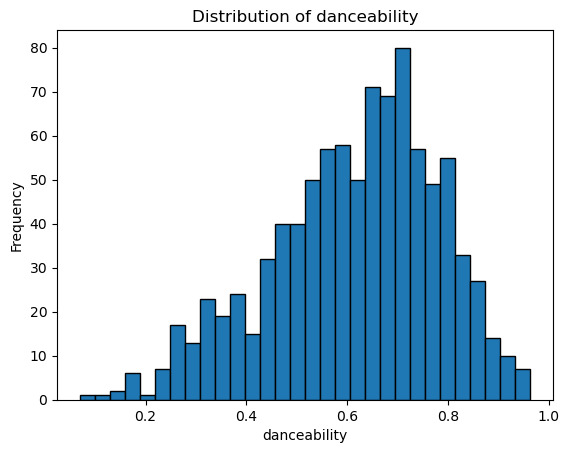

<Figure size 640x480 with 0 Axes>

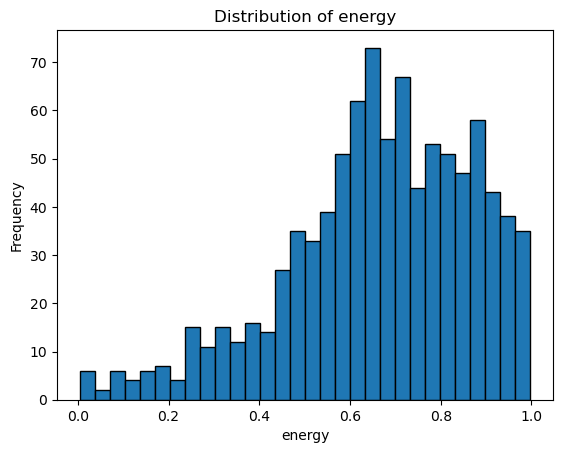

<Figure size 640x480 with 0 Axes>

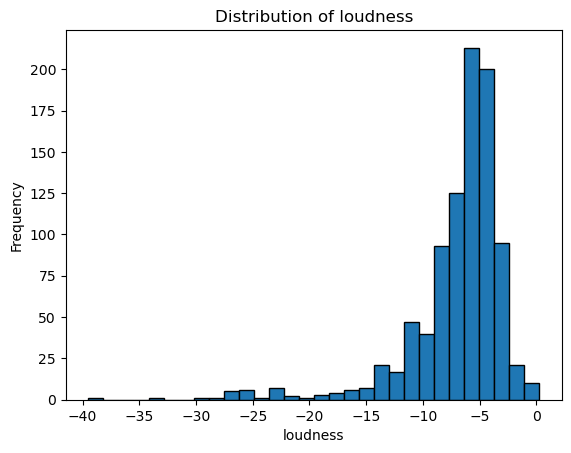

<Figure size 640x480 with 0 Axes>

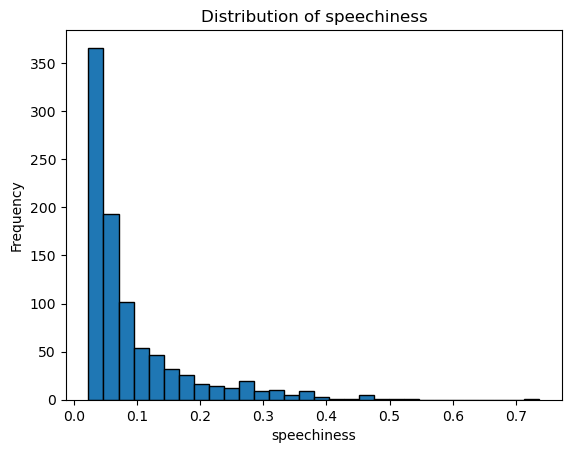

<Figure size 640x480 with 0 Axes>

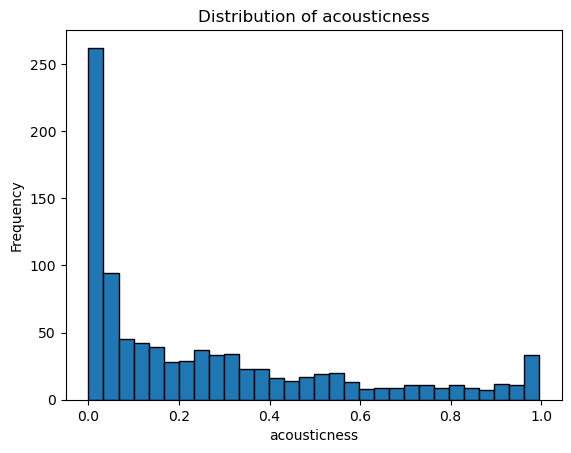

<Figure size 640x480 with 0 Axes>

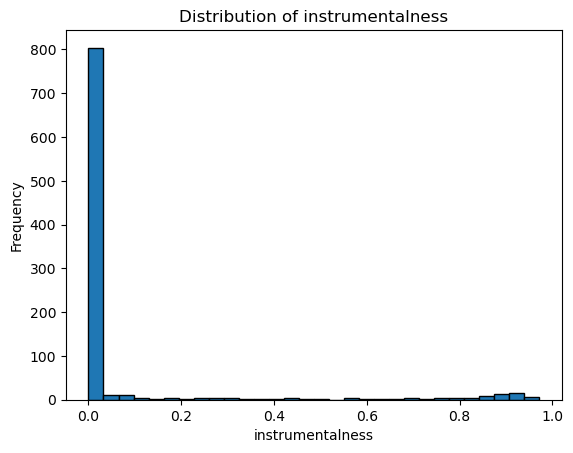

<Figure size 640x480 with 0 Axes>

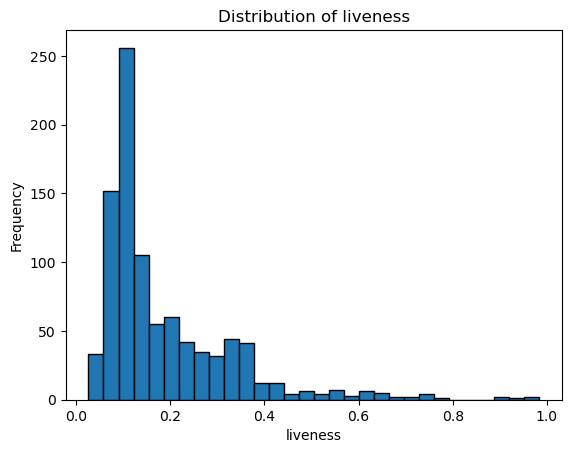

<Figure size 640x480 with 0 Axes>

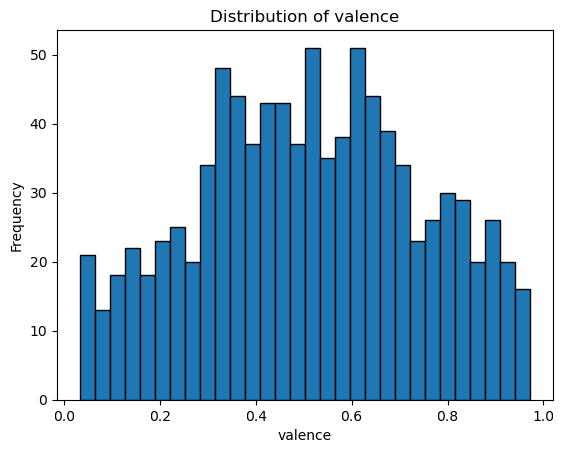

<Figure size 640x480 with 0 Axes>

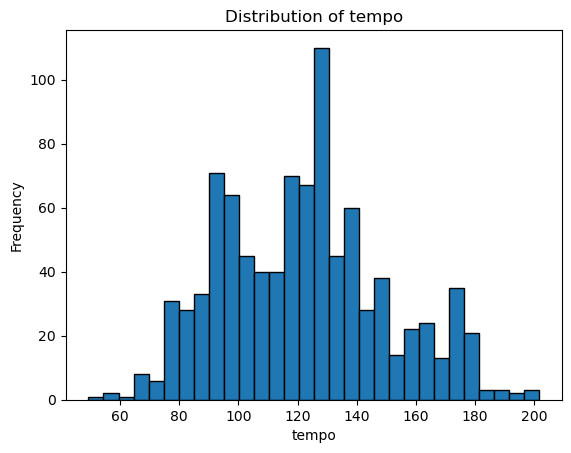

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

# Select features to explore
audio_features = [
    'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness',
    'instrumentalness', 'liveness',
    'valence', 'tempo'
]

# 1. Histograms
for feat in audio_features:
    plt.figure()
    plt.hist(df[feat], bins=30, edgecolor='black')
    plt.title(f'Distribution of {feat}')
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.show()

 # Save each plot with the feature name
    plt.savefig(f'{feat}_histogram.png', dpi=300, bbox_inches='tight')  # Save before plt.show()
    plt.show()

#### A few quick observations:
#### Acousticness & Instrumentalness are heavily right-skewed: most tracks score near zero, with a small tail of highly acoustic/instrumental tracks.
#### Danceability & Energy cluster in the mid-to-high range (around 0.6–0.8), reflecting typical pop-oriented songs.
#### Loudness centers around (-5 to –10 dB ), with very few extremely quiet (–30 dB) or extremely loud (0 dB) outliers.
#### Tempo peaks around 115–130 BPM, the “sweet spot” for danceable music.
#### Valence is fairly spread out across the 0–1 range, suggesting you have both upbeat and moody tracks.

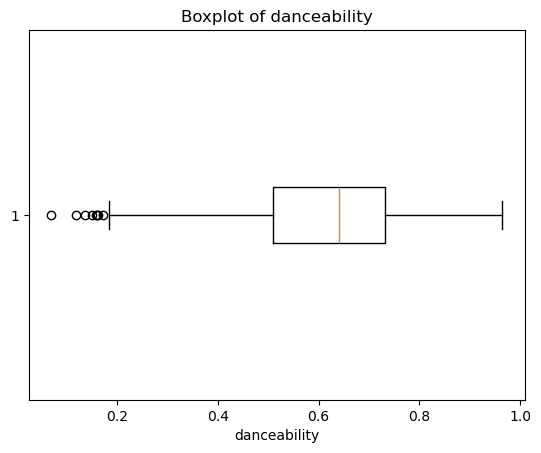

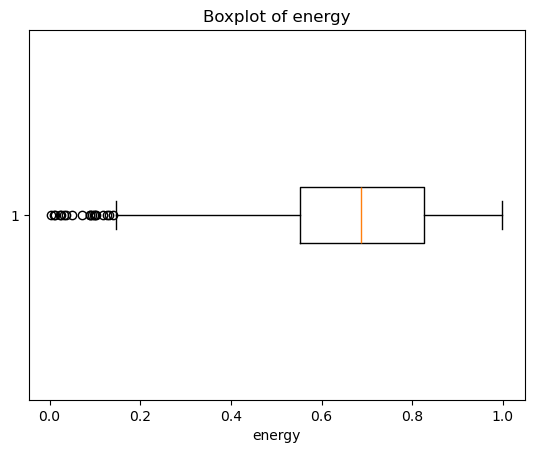

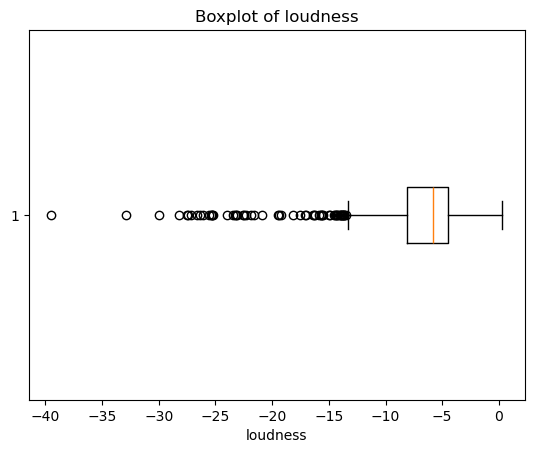

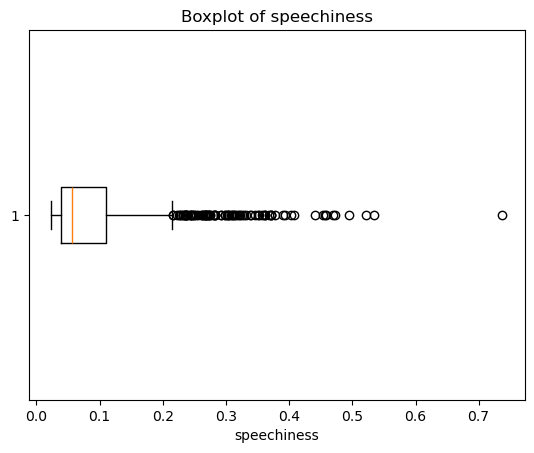

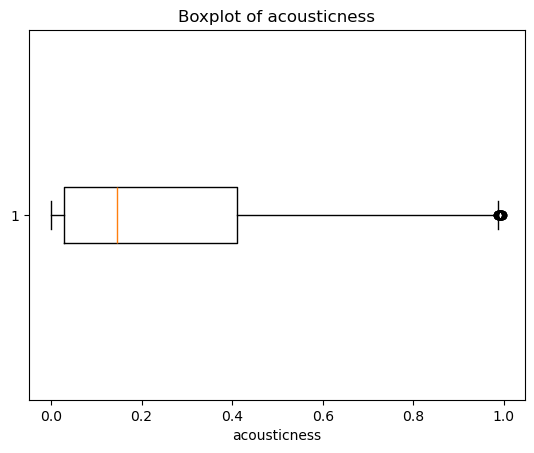

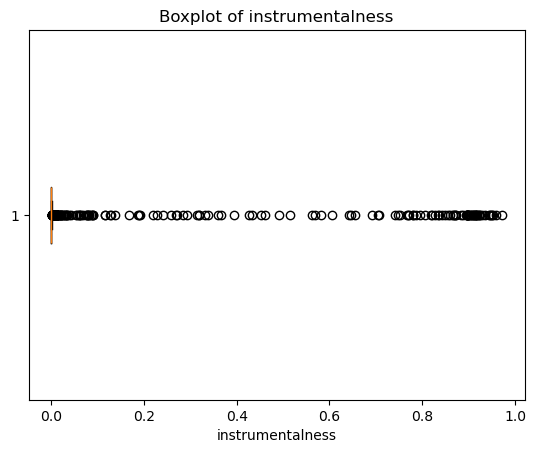

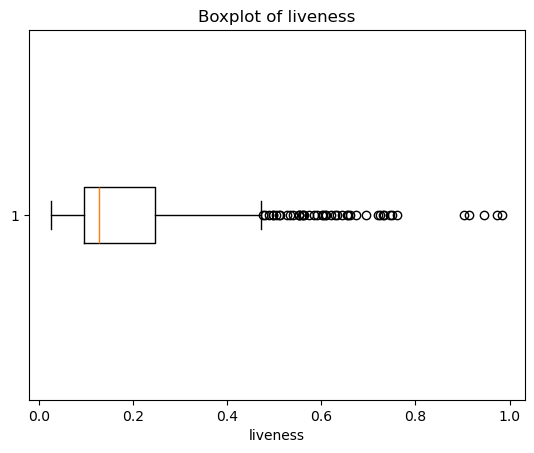

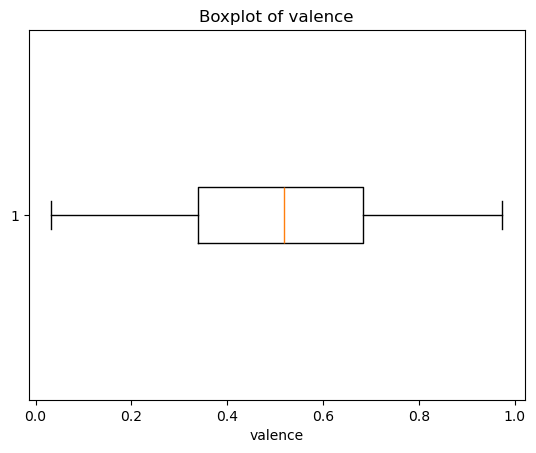

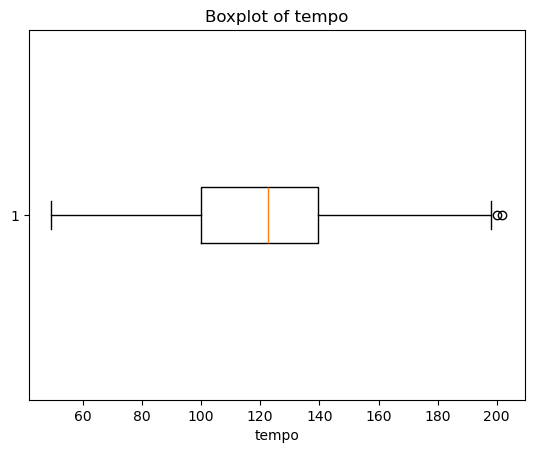

<Figure size 640x480 with 0 Axes>

In [28]:
# 2. Boxplots
for feat in audio_features:
    plt.figure()
    plt.boxplot(df[feat], vert=False)
    plt.title(f'Boxplot of {feat}')
    plt.xlabel(feat)
    plt.show()
plt.savefig('hist_danceability.jpg')


## Boxplot Analysis of Audio Features

### Danceability
-- Most tracks have high danceability, with a few low outliers indicating less danceable songs.
### Energy
-- Energy levels are consistently high across tracks, suggesting upbeat and intense music is common in the dataset.
### Instrumentalness
-- The majority of tracks include vocals (very low instrumentalness), with a few purely instrumental songs as upper outliers.
### Liveness
-- Most tracks are studio-produced, indicated by low liveness values. A few high outliers represent live or concert recordings.
### Loudness
-- Loudness values are fairly consistent and high (closer to 0 dB), as expected from professionally mastered tracks.
### Speechiness
-- Speechiness is generally low, implying that the dataset consists mostly of traditional music. Outliers may include rap or spoken-word tracks.
### Tempo
-- Tempo shows a wide range, with a central tendency around 110–120 BPM. This reflects diversity in genre and mood.
### Valence
-- Valence values are spread out, indicating a balance of both happy and sad/emotional songs in the dataset.
### Acousticness
-- While most tracks are electronically produced (low acousticness), some songs are highly acoustic, 
likely from genres like folk or classical.

### Bivariate Relationships via Correlation

In [33]:
import numpy as np

# Compute the correlation matrix
corr = df[audio_features].corr()

# Print out strongly correlated pairs
strong_pairs = [
    (f1, f2, corr.loc[f1, f2])
    for i, f1 in enumerate(audio_features)
    for f2 in audio_features[i+1:]
    if abs(corr.loc[f1, f2]) > 0.6
]
print("Strong correlations (|r| > 0.6):")
for f1, f2, r in strong_pairs:
    print(f"  {f1} ↔ {f2}: r = {r:.2f}")


Strong correlations (|r| > 0.6):
  energy ↔ loudness: r = 0.77
  energy ↔ acousticness: r = -0.68


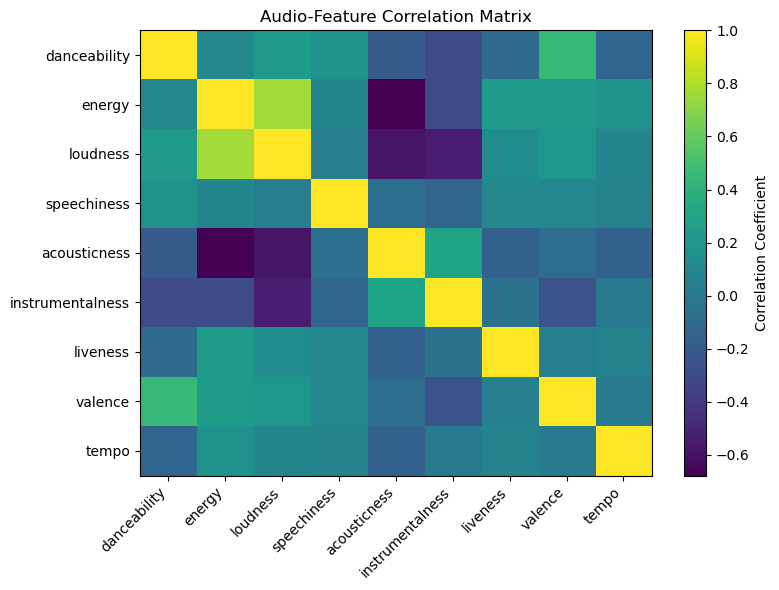

In [32]:
# Plot a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(ticks=np.arange(len(audio_features)), labels=audio_features, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(audio_features)), labels=audio_features)
plt.title('Audio-Feature Correlation Matrix')
plt.tight_layout()
plt.show()

### Genre Analysis

In [35]:
# -- Genre Frequency:  let’s see which genres dominate the dataset:

# Count how many tracks per primary_genre
genre_counts = df['primary_genre'].value_counts()

# Show the top 10 genres
top_genres = genre_counts.head(10)
print("Top 10 genres by track count:")
print(top_genres)

Top 10 genres by track count:
primary_genre
Unknown              161
dance pop             77
pop                   48
alternative metal     42
atl hip hop           37
alt z                 30
bachata               20
banda                 20
album rock            20
electro house         20
Name: count, dtype: int64


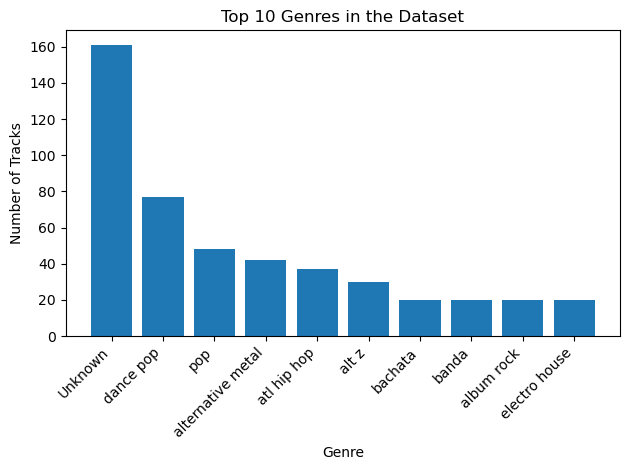

In [36]:
# Bar chart of the top genres
import matplotlib.pyplot as plt

plt.figure()
plt.bar(top_genres.index, top_genres.values)
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')
plt.title('Top 10 Genres in the Dataset')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [37]:
# --Audio-Feature Profiles by Genre-- 

# Select only tracks in the top genres
top_genre_list = top_genres.index.tolist()
df_top = df[df['primary_genre'].isin(top_genre_list)]

# Compute mean values for each audio feature by genre
genre_feature_means = (
    df_top
    .groupby('primary_genre')[audio_features]
    .mean()
    .loc[top_genre_list]   # preserve top-genre order
)

print("Mean audio-feature values for top genres:")
print(genre_feature_means)

Mean audio-feature values for top genres:
                   danceability    energy  loudness  speechiness  \
primary_genre                                                      
Unknown                0.604472  0.633528 -8.435106     0.122477   
dance pop              0.652143  0.720545 -5.308727     0.080078   
pop                    0.646062  0.681479 -5.790250     0.074054   
alternative metal      0.448167  0.863238 -5.176810     0.061455   
atl hip hop            0.783784  0.652459 -6.165027     0.159722   
alt z                  0.668567  0.617000 -5.857967     0.089053   
bachata                0.780600  0.660650 -6.902150     0.078985   
banda                  0.717500  0.606350 -5.680200     0.050450   
album rock             0.462600  0.724800 -7.828900     0.045460   
electro house          0.628050  0.765100 -5.228600     0.059725   

                   acousticness  instrumentalness  liveness   valence  \
primary_genre                                                       

## As we can see average: 
### Danceability & Energy
– Highest in atl hip hop, bachata, and banda—genres built for movement.
– Lower in alternative metal and album rock, where intensity comes from distortion rather than groove.
- Energy is highest in alternative metal, electro house.
### Acousticness & Instrumentalness
– Nearly zero for alternative metal, pop, and electro house, confirming these are highly produced, electric genres.
– Modest in bachata and banda, reflecting their mix of live instrumentation and vocals.

### Loudness
– Electro house and alternative metal are the loudest (around –5 dB).
– Album rock sits around –7.8 dB, perhaps due to mastering choices or dynamic range.

### Valence (Mood)
– Very high in banda (0.85) and bachata (0.78)—uplifting, major-key traditions.
– Lowest in electro house (0.41), hinting at darker or more aggressive tonalities.

### Tempo
– Fastest in alternative metal and bachata (130+ BPM).
– Slowest in pop (~116 BPM), matching radio-friendly mid-tempo.

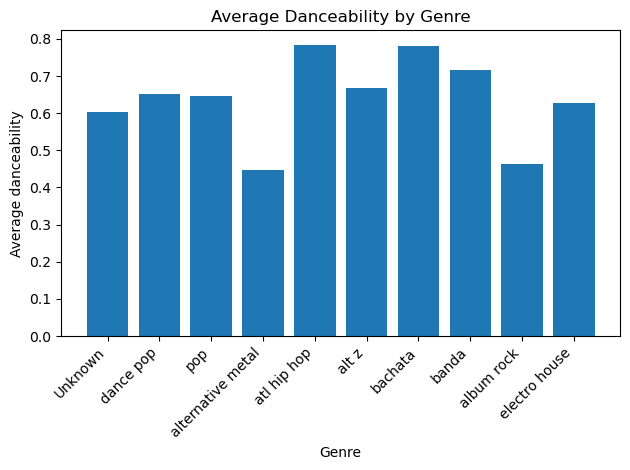

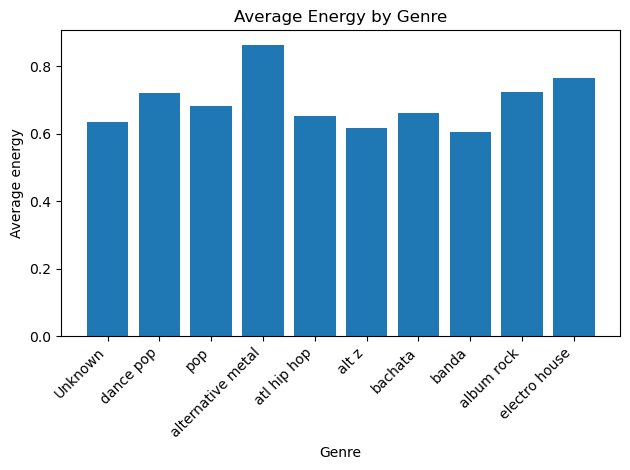

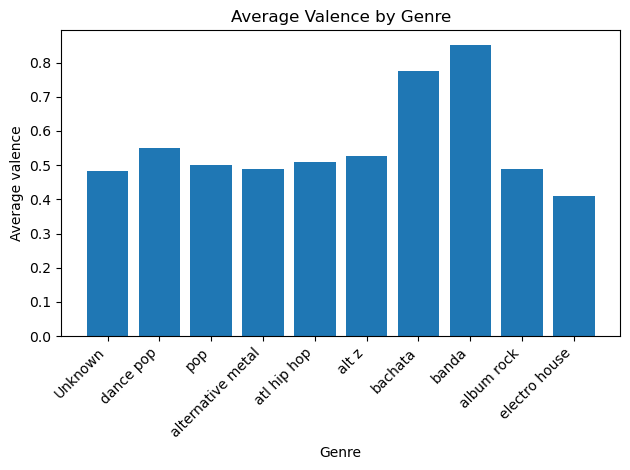

In [38]:
# Plot a few key features side by side.
for feat in ['danceability', 'energy', 'valence']:
    plt.figure()
    # Use the genre_feature_means Series for plotting
    plt.bar(genre_feature_means.index, genre_feature_means[feat])
    plt.xlabel('Genre')
    plt.ylabel(f'Average {feat}')
    plt.title(f'Average {feat.capitalize()} by Genre')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Time Series Trends: Let’s now examine how some of these key features (e.g., track_popularity, energy, valence) evolve over time.

In [41]:
# Aggregate by month
time_df = (
    df
    .groupby('release_month')
    .agg({
        'track_popularity': 'mean',
        'energy': 'mean',
        'valence': 'mean'
    })
    .sort_index()
)

time_df

,track_popularity,energy,valence
release_month,,,
1972-01,63.000000,0.743500,0.771000
1973-01,82.000000,0.476000,0.234000
1975-04,74.000000,0.745000,0.692500
1976-01,47.500000,0.311500,0.348500
1976-05,75.500000,0.811000,0.483500
...,...,...,...
2024-04,70.076923,0.681846,0.470846
2024-05,70.777778,0.712852,0.553630
2024-06,67.230769,0.687231,0.481765


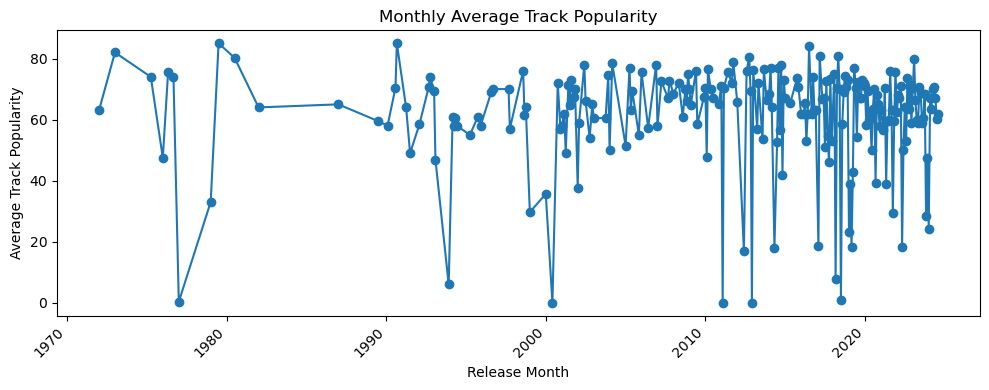

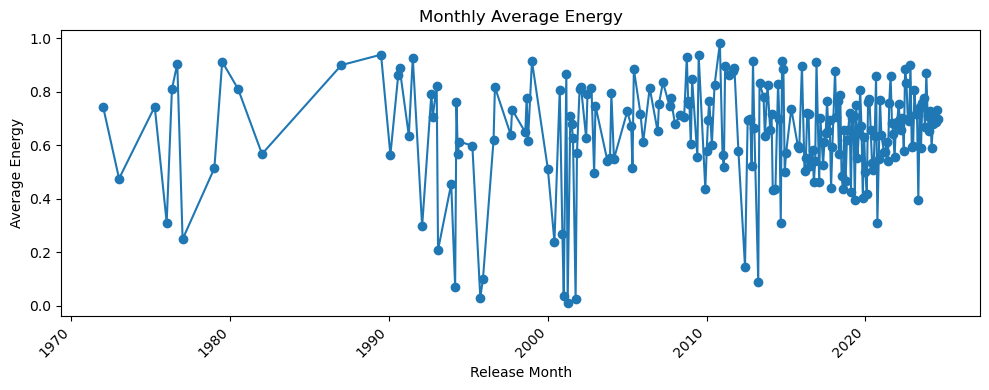

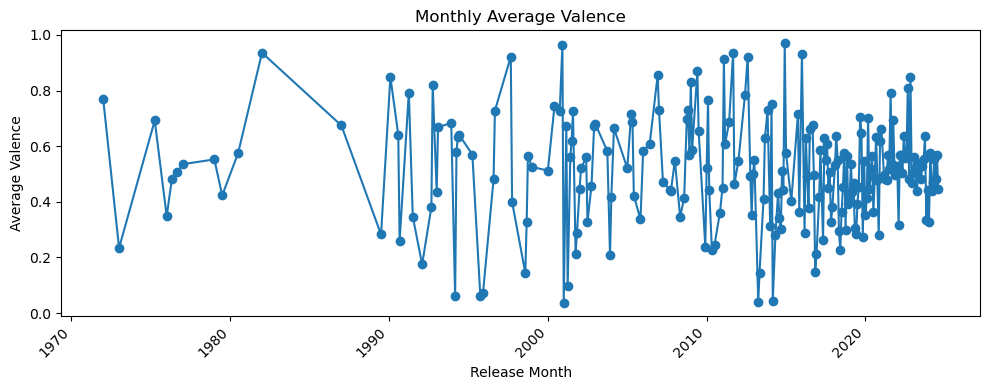

In [40]:
# Plot each metric as a line over time
for metric in ['track_popularity', 'energy', 'valence']:
    plt.figure(figsize=(10,4))
    plt.plot(time_df.index.to_timestamp(), time_df[metric], marker='o')
    plt.title(f'Monthly Average {metric.replace("_", " ").title()}')
    plt.xlabel('Release Month')
    plt.ylabel(f'Average {metric.replace("_", " ").title()}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Track Popularity Trends

##### There's considerable variation in popularity over time. For example, tracks from 1973-01 (Jan 1973) had a notably high average popularity of 82, while other months like 1976-01 show much lower popularity (~47.5).
##### Recent years (2020s) show relatively stable popularity, hovering around 60–70, suggesting more consistent chart performance or broader streaming distribution.

### Energy Levels
##### Energy values have generally remained high in most months, especially post-2000. For instance, 2024-05 has a high energy average of ~0.71, indicating an ongoing preference for upbeat music.
##### Notably, older months like 1976-01 had lower energy levels (~0.31), possibly reflecting different production styles or genre preferences (e.g., softer ballads, folk, or jazz).

### Valence Patterns (Musical Positivity)
##### Valence shows high fluctuation across months, reflecting varying emotional tones in music. For instance:
##### 1973-01 has a low average valence (~0.23), suggesting emotionally darker or sadder songs.
##### 1972-01 and 1975-04 feature higher valence (~0.77 and ~0.69), suggesting more cheerful tracks.
##### In modern years, valence appears moderately positive, typically ranging between 0.45–0.55, implying a balanced emotional mix in contemporary music.